# **Import Library**

**Import Library**

In [ ]:
import pandas as pd
import numpy as np
import bokeh
from bokeh.io import output_file, output_notebook
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, Panel, Tabs
from bokeh.layouts import row, column, gridplot
from bokeh.models.widgets import Tabs, Panel
from bokeh.models.tools import HoverTool
from bokeh.models.annotations import Title
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from scipy import stats
import random
from random import gauss
from random import seed
from pandas import Series
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta
import sklearn.metrics as metrics
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Input Dataset**

In [ ]:
#IMPORT DATA
data = pd.read_csv('DatasetTA6.csv')
df = pd.read_csv('DatasetTA6.csv', index_col=0, parse_dates=True)
#data=data.drop(["Kurs_Dollar"],axis=1)
data

,Tanggal,Harga_Antam
0,2020-07-01,919000
1,2020-07-02,915000
2,2020-07-03,928000
3,2020-07-04,930000
4,2020-07-05,930000
...,...,...
179,2020-12-27,973000
180,2020-12-28,977000
181,2020-12-29,967000
182,2020-12-30,965000


**Ubah format tanggal pada dataset**

In [ ]:
#UBAH FORMAT PADA DATASET
data["Tanggal"] = pd.to_datetime(data["Tanggal"], format='%Y/%m/%d')

**Plot keseluruhan dataset**

In [ ]:
#Memanggil fungsi untuk keluar grafik di notebook yang sama
output_notebook()
 
#buat source
source = ColumnDataSource(data)
 
#membuat figure
awal = figure(x_axis_type='datetime', x_axis_label='Tanggal', y_axis_label='Harga Logam Mulia Antam')
awal.line(x="Tanggal", y="Harga_Antam", source = source, line_width=2, legend_label="Harga Logam Mulia Antam", color='deepskyblue')
awal.legend.location = 'top_left'
 
#membuat hover
hover1 = HoverTool()
hover1.tooltips = [('IDR ','@Harga_Antam')]
awal.add_tools(hover1)
 
 
#menampilkan grafik
show(awal)



# **================= MODEL ARIMA =================**


---



**MENYETEL NILAI GALAT PADA SAAT t (Et)**

In [ ]:
#NILAI KESALAHAN ET dari buat white noise

#seed random number generator
seed(1)

#buat list white noise
series = [gauss(0.0,1.0) for i in range(len(data))]
series = Series(series)

data["et"] = series

**UJI STATIONERITAS**

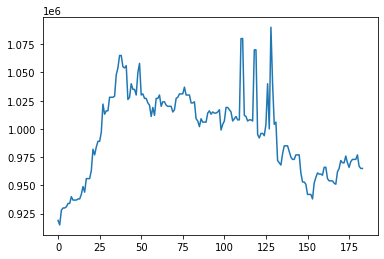

In [ ]:
#Plot data harga logam mulia Antam
data['Harga_Antam'].dropna().plot()

In [ ]:
#Membuat fungsi ADF Testing
def ADF_Test(data):
    result = adfuller(data)
    print('p-value: %f' % result[1])
    if result[1] > 0.05:
      print("Data tidak stasionaire")
      print()
      print()
    else:
      print("Data Stasionaire")
      print()
      print()
ADF_Test(data["Harga_Antam"])

p-value: 0.268360
Data tidak stasionaire




Hasil test ADF menunjukan P-Values diatas 0.05 (taraf signifikan 5%) maka dataset bukanlah data stasionaire

**DIFFERENCING**

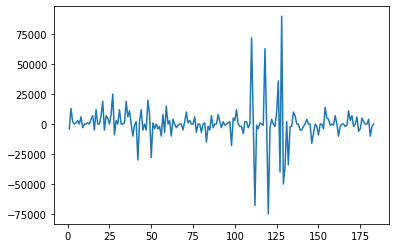

In [ ]:
#Differencing
data['diff'] = data['Harga_Antam'] - data['Harga_Antam'].shift(1)

#Plot data differencing
data['diff'].dropna().plot()

In [ ]:
#uji stasioneritas menggunakan data differencing
ADF_Test(data["diff"].dropna())

p-value: 0.000000
Data Stasionaire




Karena hasil uji yang dihasilkan menunjukan p-values = 0.000 yang berarti p-values < 0.05 (taraf signifikan 5%) maka dataset sudah stasioner

**IDENTIFIKASI (p,d,q)**

**Plot ACF dan PACF menggunakan data differencing**

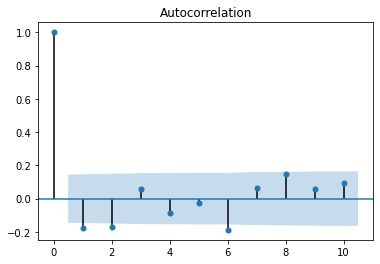

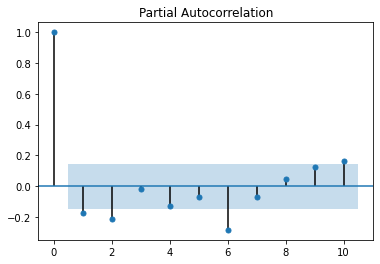

In [ ]:
#Plot ACF untuk menentukan parameter q
sm.graphics.tsa.plot_acf(data["diff"].dropna(),lags=10)

#Plot PACF untuk menentukan parameter p
sm.graphics.tsa.plot_pacf(data["diff"].dropna(),lags=10)

#Parameter d didapat dari jumlah derajat differencing (d=1)

plt.show()

**Penentuan model ARIMA terbaik menggunakan AIC**

In [ ]:
aic = []
for m in range(3):
    mod= ARIMA(data["Harga_Antam"].dropna(), order=(0,1,m))
    mod = mod.fit(disp=-1)
    aic.append([0,1,m,mod.aic])

for d in range(3):
    mode= ARIMA(data["Harga_Antam"].dropna(), order=(1,1,d))
    mode = mode.fit(disp=-1)
    aic.append([1,1,d,mode.aic])

for w in range(2):
    moe = ARIMA(data["Harga_Antam"].dropna(), order=(2,1,w))
    moe = moe.fit(disp=-1)
    aic.append([2,1,w,moe.aic])
aic

[[0, 1, 0, 4053.651589903932],
 [0, 1, 1, 4046.496699231169],
 [0, 1, 2, 4039.8850657524877],
 [1, 1, 0, 4049.963611483886],
 [1, 1, 1, 4040.8189092036896],
 [1, 1, 2, 4041.830664983507],
 [2, 1, 0, 4043.9507096330995],
 [2, 1, 1, 4042.17724765419]]

In [ ]:
model212 = ARIMA(data["Harga_Antam"].dropna(), order=(2,1,2))
model212 = model212.fit(disp=-1)
model212.aic

ValueError: ignored

Karena model ARIMA (2,1,2) tidak bisa maka model ini di tiadakan dan berdasarkan hasil AIC menunjukan bahwa model ARIMA (0,1,2) merupakan model ARIMA terbaik dengan nilai AIC 4039

**MENENTUKAN PARAMETER**

In [ ]:
model = ARIMA(data["Harga_Antam"].dropna(), order=(0,1,2))
model = model.fit(disp=-1)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:          D.Harga_Antam   No. Observations:                  183
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -2015.943
Method:                       css-mle   S.D. of innovations          14713.008
Date:                Mon, 20 Sep 2021   AIC                           4039.885
Time:                        05:39:34   BIC                           4052.723
Sample:                             1   HQIC                          4045.089
                                                                              
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 251.3661    557.674      0.451      0.653    -841.656    1344.388
ma.L1.D.Harga_Antam    -0.2395      0.074     -3.247      0.001      -0.384      -0.095
ma.L2.D.Harga_Antam    -0.2519      0.079     -3.193      0.002      -0.406      -0.097
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.5730           +0.0000j            1.5730            0.0000
MA.2           -2.5239           +0.0000j            2.5239            0.5000
-----------------------------------------------------------------------------
"""

melihat dari p-value pada kolom "P>|z|", hasil menunjukan bahwa p-value < 0.05 yang berarti model ARIMA ini sudah signifikan

**CEK DIAGNOSA MENGGUNAKAN UJI LJUNG BOX UNTUK MENGETAHUI AUTOKORELASI RESIDUAL**

In [ ]:
import statsmodels.api as sm
res2 = sm.tsa.ARIMA(data["Harga_Antam"].dropna(), (0,1,2)).fit()
ljungbox=[]
for m in range(5):
  m+=1
  h2 = sm.stats.acorr_ljungbox(res2.resid, lags=[m])
  ljungbox.append([m, h2[1]])
print(ljungbox)

[[1, array([0.99981456])], [2, array([0.89291165])], [3, array([0.93540126])], [4, array([0.53575828])], [5, array([0.60890454])]]


In [ ]:
data['residu']=res2.resid

# 
**BERDASARKAN HASIL UJI SIGNIFIKAN, LJUNG BOX, DAN NILAI AIC MEMBUKTIKAN BAHWA MODEL ARIMA (0,1,2) MERUPAKAN MODEL TERBAIK**

In [ ]:
#SKENARIO A - SPLIT DATA 80% DATA TRAINING DAN 20% DATA TESTING
size1 = int(len(data)*0.80)
trainer1 = data[0:size1]
test1 = data[size1:len(data)]
test11 = data[size1-2:len(data)]

#SKENARIO B - SPLIT DATA 90% DATA TRAINING DAN 10% DATA TESTING
size2 = int(len(data)*0.90)
trainer2 = data[0:size2]
test2 = data[size2:len(data)]
test22 = data[size2-2:len(data)]

#SKENARIO C - SPLIT DATA 95% DATA TRAINING DAN 5% DATA TESTING
size3 = int(len(data)*0.95)
trainer3 = data[0:size3]
test3 = data[size3:len(data)]
test33 = data[size3-2:len(data)]

Dataset dibagi menjadi tiga skenario dengan jumlah data latih dan uji yang berbeda-beda, adapun tiga skenario yang dilakukan adalah skenario A terdapat 80% data latih dan 20% data uji sedangkan skenario B terdapat 90% data latih dan 10% data uji lalu skenario C terdapat 95% data latih dan 5% data uji

In [ ]:
#MEMBUAT SOURCE UNTUK PLOT SKENARIO
sourceT1 = ColumnDataSource(trainer1)
sourceT2 = ColumnDataSource(trainer2)
sourceT3 = ColumnDataSource(trainer3)
source1 = ColumnDataSource(test1)
source2 = ColumnDataSource(test2)
source3 = ColumnDataSource(test3)

In [ ]:
#PLOT DATA LATIH DAN UJI SKENARIO A
output_notebook()

#membuat figure
sk1 = figure(x_axis_type='datetime', x_axis_label='Tanggal', y_axis_label='Harga Logam Mulia Antam')
sk1.line(x="Tanggal", y="Harga_Antam", source = sourceT1, line_width=2, legend_label="Data Latih", color='deepskyblue')
sk1.line(x="Tanggal", y="Harga_Antam", source = source1, line_width=2, legend_label="Data Uji", color='tomato')
sk1.legend.location = 'top_left'
sk1.title="Skenario A"
show(sk1)

In [ ]:
#PLOT DATA LATIH DAN UJI SKENARIO B
output_notebook()

#membuat figure
sk2 = figure(x_axis_type='datetime', x_axis_label='Tanggal', y_axis_label='Harga Logam Mulia Antam')
sk2.line(x="Tanggal", y="Harga_Antam", source = sourceT2, line_width=2, legend_label="Data Latih", color='deepskyblue')
sk2.line(x="Tanggal", y="Harga_Antam", source = source2, line_width=2, legend_label="Data Uji", color='tomato')
sk2.legend.location = 'top_left'
sk2.title="Skenario B"
show(sk2)

In [ ]:
#PLOT DATA LATIH DAN UJI SKENARIO C
output_notebook()

#membuat figure
sk3 = figure(x_axis_type='datetime', x_axis_label='Tanggal', y_axis_label='Harga Logam Mulia Antam')
sk3.line(x="Tanggal", y="Harga_Antam", source = sourceT3, line_width=2, legend_label="Data Latih", color='deepskyblue')
sk3.line(x="Tanggal", y="Harga_Antam", source = source3, line_width=2, legend_label="Data Uji", color='tomato')
sk3.legend.location = 'top_left'
sk3.title="Skenario C"
show(sk3)

**MEMBANGUN FUNGSI PERAMALAN UNTUK MODEL ARIMA MENGGUNAKAN MODEL ARIMA (0,1,2)**

In [ ]:
def prediksiArima(test1, test11, s, theta1, theta2):
  ai = 0
  predArima = []
  for i in range(len(test1)):
    ab = s+test11.iloc[ai+1][1]+test11.iloc[ai+2][2]-theta1*test11.iloc[ai+1][2]-theta2*test11.iloc[ai][2]
    ai+=1
    predArima.append(ab)
  return tuple(predArima)

**MODEL ARIMA - SKENARIO A**

In [ ]:
#MEMBANGUN MODEL DENGAN DATA LATIH SKENARIO A
model1 = ARIMA(trainer1["Harga_Antam"].dropna(), order=(0,1,2))
model1 = model1.fit(disp=-1)
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:          D.Harga_Antam   No. Observations:                  146
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -1622.333
Method:                       css-mle   S.D. of innovations          16187.713
Date:                Mon, 20 Sep 2021   AIC                           3252.666
Time:                        05:40:54   BIC                           3264.600
Sample:                             1   HQIC                          3257.515
                                                                              
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 320.9787    652.419      0.492      0.623    -957.738    1599.696
ma.L1.D.Harga_Antam    -0.2594      0.083     -3.141      0.002      -0.421      -0.098
ma.L2.D.Harga_Antam    -0.2590      0.086     -3.010      0.003      -0.428      -0.090
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.5269           +0.0000j            1.5269            0.0000
MA.2           -2.5284           +0.0000j            2.5284            0.5000
-----------------------------------------------------------------------------
"""

In [ ]:
#MERAMALKAN HARGA LOGAM MULIA ANTAM DENGAN DATA UJI SKENARIO A
test1["Peramalan_Arima"] = prediksiArima(test1, test11, 320.97, -0.2594, -0.2590)

#PERIKSA MEAN ABSOLUTE ERROR YANG TERJADI
import sklearn.metrics as metrics
maec = metrics.mean_absolute_error(test1['Harga_Antam'], test1['Peramalan_Arima'])
print("Hasil dari prediksi pada skenario 1 menggunakan data Harga Antam:")
print("MAE:",maec)

Hasil dari prediksi pada skenario 1 menggunakan data Harga Antam:
MAE: 3697.4840284242778


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


**MODEL ARIMA - SKENARIO B**

In [ ]:
#MEMBANGUN MODEL DENGAN DATA LATIH SKENARIO B
model2 = ARIMA(trainer2["Harga_Antam"].dropna(), order=(0,1,2))
model2 = model2.fit(disp=-1)
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:          D.Harga_Antam   No. Observations:                  164
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -1814.706
Method:                       css-mle   S.D. of innovations          15453.729
Date:                Mon, 20 Sep 2021   AIC                           3637.412
Time:                        05:41:03   BIC                           3649.811
Sample:                             1   HQIC                          3642.446
                                                                              
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 213.4146    616.501      0.346      0.730    -994.906    1421.735
ma.L1.D.Harga_Antam    -0.2418      0.078     -3.105      0.002      -0.394      -0.089
ma.L2.D.Harga_Antam    -0.2519      0.083     -3.041      0.003      -0.414      -0.090
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.5694           +0.0000j            1.5694            0.0000
MA.2           -2.5291           +0.0000j            2.5291            0.5000
-----------------------------------------------------------------------------
"""

In [ ]:
#MERAMALKAN HARGA LOGAM MULIA ANTAM DENGAN DATA UJI SKENARIO B
test2["Peramalan_Arima"] = prediksiArima(test2, test22, 213.41, -0.2418, -0.2519)

#PERIKSA MEAN ABSOLUTE ERROR YANG TERJADI
import sklearn.metrics as metrics
maef = metrics.mean_absolute_error(test2['Harga_Antam'], test2['Peramalan_Arima'])
print("Hasil dari prediksi pada skenario 1 menggunakan data Harga Antam:")
print("MAE:",maef)

Hasil dari prediksi pada skenario 1 menggunakan data Harga Antam:
MAE: 3477.009928043613


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


**MODEL ARIMA - SKENARIO C**

In [ ]:
#MEMBANGUN MODEL DENGAN DATA LATIH SKENARIO C
model3 = ARIMA(trainer3["Harga_Antam"].dropna(), order=(0,1,2))
model3 = model3.fit(disp=-1)
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:          D.Harga_Antam   No. Observations:                  173
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -1910.287
Method:                       css-mle   S.D. of innovations          15100.782
Date:                Mon, 20 Sep 2021   AIC                           3828.575
Time:                        06:10:09   BIC                           3841.188
Sample:                             1   HQIC                          3833.692
                                                                              
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 295.8016    591.488      0.500      0.618    -863.493    1455.097
ma.L1.D.Harga_Antam    -0.2390      0.076     -3.148      0.002      -0.388      -0.090
ma.L2.D.Harga_Antam    -0.2503      0.081     -3.078      0.002      -0.410      -0.091
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.5775           +0.0000j            1.5775            0.0000
MA.2           -2.5325           +0.0000j            2.5325            0.5000
-----------------------------------------------------------------------------
"""

In [ ]:
#MERAMALKAN HARGA LOGAM MULIA ANTAM DENGAN DATA UJI SKENARIO C
test3["Peramalan_Arima"] = prediksiArima(test3, test33, 294.67, -0.2390, -0.2503)

#PERIKSA MEAN ABSOLUTE ERROR YANG TERJADI
import sklearn.metrics as metrics
maed = metrics.mean_absolute_error(test3['Harga_Antam'].dropna(), test3['Peramalan_Arima'].dropna())
print("Hasil dari prediksi pada skenario 1 menggunakan data Harga Antam:")
print("MAE:",maed)

Hasil dari prediksi pada skenario 1 menggunakan data Harga Antam:
MAE: 3417.900262278027


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


**Hasil peramalan yang telah diberikan oleh model ARIMA dengan menggunakan model ARIMA (0,1,2) menunjukan bahwa model ini sangat baik dalam melakukan peramalan harga logam mulia Antam dengan mempunyai nilai MAE (Mean Absolute Error) rentang 3.000 pada setiap skenario.**

# ============== MODEL SUPPORT VECTOR REGRESSION ==============

**PREPROCESSING DATA**

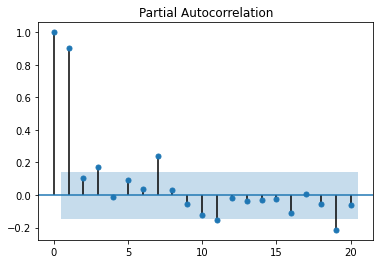

In [ ]:
#MEMBUAT GRAFIK PACF UNTUK MENENTUKAN VARIABEL INDEPENDENT
sm.graphics.tsa.plot_pacf(data["Harga_Antam"].dropna(),lags=20)

plt.show()

In [ ]:
#MEMBUAT DATA LAG (VARIABEL INDEPENDENT) BERDASARKAN HASIL PACF
number_lags = 20
for lag in range(1, number_lags + 1):
    data['lag_' + str(lag)] = data.Harga_Antam.shift(lag)
    data['lag_' + str(lag)]= data['lag_' + str(lag)].replace(np.nan, 0) 
data

,Tanggal,Harga_Antam,et,diff,residu,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20
0,2020-07-01,919000,1.288185,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-07-02,915000,1.449446,-4000.0,-4251.366117,919000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-07-03,928000,0.066336,13000.0,12069.008054,915000.0,919000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-07-04,930000,-0.764544,2000.0,3218.133588,928000.0,915000.0,919000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-07-05,930000,-1.092173,0.0,3256.940480,930000.0,928000.0,915000.0,919000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,2020-12-27,973000,0.130496,0.0,344.084085,973000.0,973000.0,971000.0,966000.0,970000.0,976000.0,970000.0,970000.0,972000.0,965000.0,962000.0,951000.0,952000.0,954000.0,954000.0,954000.0,956000.0,966000.0,966000.0,959000.0
180,2020-12-28,977000,0.201145,4000.0,4045.376719,973000.0,973000.0,973000.0,971000.0,966000.0,970000.0,976000.0,970000.0,970000.0,972000.0,965000.0,962000.0,951000.0,952000.0,954000.0,954000.0,954000.0,956000.0,966000.0,966000.0
181,2020-12-29,967000,-0.191960,-10000.0,-9195.845821,977000.0,973000.0,973000.0,973000.0,971000.0,966000.0,970000.0,976000.0,970000.0,970000.0,972000.0,965000.0,962000.0,951000.0,952000.0,954000.0,954000.0,954000.0,956000.0,966000.0
182,2020-12-30,965000,1.081242,-2000.0,-3434.788668,967000.0,977000.0,973000.0,973000.0,973000.0,971000.0,966000.0,970000.0,976000.0,970000.0,970000.0,972000.0,965000.0,962000.0,951000.0,952000.0,954000.0,954000.0,954000.0,956000.0


In [ ]:
#MEMASUKAN HARGA LOGAM MULIA ANTAM KE DALAM PANDAS DATAFRAME UNTUK LEBIH BISA DI LIAHT
adj = data["Harga_Antam"]
dfd = pd.DataFrame({'ANTAM':adj})
dfd

,ANTAM
0,919000
1,915000
2,928000
3,930000
4,930000
...,...
179,973000
180,977000
181,967000
182,965000


In [ ]:
#MENGHAPUS FEATURES DATA YANG TIDAK TERMASUK VARIABEL INDEPENDENT
dars = data
dars=dars.drop(['Tanggal','Harga_Antam','et','diff','residu','lag_2','lag_4','lag_5','lag_6','lag_8',
                'lag_9','lag_10','lag_12','lag_13','lag_14','lag_15','lag_16','lag_17','lag_18','lag_20'], axis=1)
dars

,lag_1,lag_3,lag_7,lag_11,lag_19
0,0.0,0.0,0.0,0.0,0.0
1,919000.0,0.0,0.0,0.0,0.0
2,915000.0,0.0,0.0,0.0,0.0
3,928000.0,919000.0,0.0,0.0,0.0
4,930000.0,915000.0,0.0,0.0,0.0
...,...,...,...,...,...
179,973000.0,971000.0,970000.0,962000.0,966000.0
180,973000.0,973000.0,976000.0,965000.0,966000.0
181,977000.0,973000.0,970000.0,972000.0,956000.0
182,967000.0,973000.0,966000.0,970000.0,954000.0


In [ ]:
#MELAKUKAN NORMALISASI TERHADAP VARIABEL INDEPENDENT
from sklearn.preprocessing import MinMaxScaler
feature_columns = ['lag_1','lag_3','lag_7','lag_11','lag_19']
scaler = MinMaxScaler()
feature_minmax_transform_data = scaler.fit_transform(dars[feature_columns])
feature_minmax_transform = pd.DataFrame(columns=feature_columns, data=feature_minmax_transform_data, index=dars.index)
feature_minmax_transform.head(30)

,lag_1,lag_3,lag_7,lag_11,lag_19
0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.843119,0.000000,0.000000,0.000000,0.000000
2,0.839450,0.000000,0.000000,0.000000,0.000000
3,0.851376,0.843119,0.000000,0.000000,0.000000
4,0.853211,0.839450,0.000000,0.000000,0.000000
5,0.853211,0.851376,0.000000,0.000000,0.000000
6,0.854128,0.853211,0.000000,0.000000,0.000000
7,0.856881,0.853211,0.843119,0.000000,0.000000
8,0.856881,0.854128,0.839450,0.000000,0.000000
9,0.862385,0.856881,0.851376,0.000000,0.000000


In [ ]:
#MELIHAT SHAPE DARI VARIABEL INDEPENDENT DAN DEPENDENT
print('Shape of independent variable : ', feature_minmax_transform.shape)
print('Shape of dependent variable : ', dfd.shape)

Shape of independent variable :  (184, 5)
Shape of dependent variable :  (184, 1)


Membagi data latih dan uji serta melihat banyaknya sampel data latih dan valid yang akan digunakan pada metode grid search CV

In [ ]:
ts_split= TimeSeriesSplit(n_splits=10)
for train_index, test_index, in ts_split.split(feature_minmax_transform):
        X_train, X_test = feature_minmax_transform[:len(train_index)], feature_minmax_transform[len(train_index):]
        y_train, y_test = dfd[:len(train_index)], dfd[len(train_index):]
        print("fold ", "train: ", len(train_index), " ","tes: ", len(test_index))

fold  train:  24   tes:  16
fold  train:  40   tes:  16
fold  train:  56   tes:  16
fold  train:  72   tes:  16
fold  train:  88   tes:  16
fold  train:  104   tes:  16
fold  train:  120   tes:  16
fold  train:  136   tes:  16
fold  train:  152   tes:  16
fold  train:  168   tes:  16


**INISIALISASI HYPERPARAMETER**

In [ ]:
kernel = ['rbf','poly']
C = [1,10,1e2,1e3,1e4,1e5]
gamma = [0.001,0.01,0.1,1,10]
epsilon = [0.00001,0.0001,0.001,0.01,0.1,1]

**PELATIHAN MODEL SUPPORT VECTOR**

In [ ]:
svm_grid = {'kernel':kernel,'C':C,'gamma':gamma,'epsilon':epsilon}
SVM = SVR()
svm_search = GridSearchCV(SVM,svm_grid,cv=ts_split,scoring='neg_mean_absolute_error')
svm_search.fit(feature_minmax_transform,dfd)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chang

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
             error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 10, 100.0, 1000.0, 10000.0, 100000.0],
                         'epsilon': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1],
                         'gamma': [0.001, 0.01, 0.1, 1, 10],
                         'kernel': ['rbf', 'poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_absolute_error', verbose=0)

In [ ]:
#MEMASUKAN HASIL METODE GRID SEARCH CV KE DALAM PANDAS DATAFRAME
df_result = pd.DataFrame(svm_search.cv_results_)
df_result.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_epsilon,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003252,0.001042,0.001515,0.000233,1,1e-05,0.001,rbf,"{'C': 1, 'epsilon': 1e-05, 'gamma': 0.001, 'ke...",-89624.990748,-76187.479042,-7124.995926,-10312.500354,-8312.498502,-20312.499915,-28437.501121,-46437.498157,-55874.995297,-38312.495010,-38093.745407,27421.962240,313
1,0.002427,0.000561,0.001334,0.000091,1,1e-05,0.001,poly,"{'C': 1, 'epsilon': 1e-05, 'gamma': 0.001, 'ke...",-89625.000000,-76187.499999,-7125.000000,-10312.500004,-8312.500000,-20312.500005,-28437.499994,-46437.500000,-55875.000010,-38312.499990,-38093.750000,27421.966702,333
2,0.002670,0.000642,0.001375,0.000070,1,1e-05,0.01,rbf,"{'C': 1, 'epsilon': 1e-05, 'gamma': 0.01, 'ker...",-89624.909197,-76187.292856,-7124.959977,-10312.503483,-8312.485323,-20312.499157,-28437.511005,-46437.481907,-55874.953783,-38312.450872,-38093.704756,27421.922704,295
3,0.002416,0.000451,0.001313,0.000045,1,1e-05,0.01,poly,"{'C': 1, 'epsilon': 1e-05, 'gamma': 0.01, 'ker...",-89624.999813,-76187.499453,-7124.999856,-10312.500005,-8312.499927,-20312.499998,-28437.500035,-46437.499885,-55874.999749,-38312.499754,-38093.749848,27421.966593,326
4,0.003083,0.001363,0.001524,0.000445,1,1e-05,0.1,rbf,"{'C': 1, 'epsilon': 1e-05, 'gamma': 0.1, 'kern...",-89624.244234,-76185.647060,-7124.663145,-10312.529273,-8312.380006,-20312.492411,-28437.592143,-46437.348026,-55874.608784,-38312.076560,-38093.358164,27421.582303,273


**HYPERPARAMETER TERBAIK**

In [ ]:
svm_search.best_params_

{'C': 100000.0, 'epsilon': 1e-05, 'gamma': 10, 'kernel': 'rbf'}

In [ ]:
#MELIHAT SCORE PADA HYPERPARAMETER TERBAIK
abs(svm_search.best_score_)

14529.47219064128

**PEMBAGIAN DATASET**

In [ ]:
#SKENARIO A
X_train1, X_test1 = feature_minmax_transform[:len(trainer1)], feature_minmax_transform[len(trainer1):]
y_train1, y_test1 = dfd[:len(trainer1)], dfd[len(trainer1):]

#SKENARIO B
X_train2, X_test2 = feature_minmax_transform[:len(trainer2)], feature_minmax_transform[len(trainer2):]
y_train2, y_test2 = dfd[:len(trainer2)], dfd[len(trainer2):]

#SKENARIO C
X_train3, X_test3 = feature_minmax_transform[:len(trainer3)], feature_minmax_transform[len(trainer3):]
y_train3, y_test3 = dfd[:len(trainer3)], dfd[len(trainer3):]

**MODEL SVR**

SKENARIO A

In [ ]:
SVM1 = SVR(epsilon=1e-05,gamma=10,kernel='rbf',C=100000)
SVM1.fit(X_train1,y_train1)
prediction_SVR = SVM1.predict(X_test1)
mae_SVR = metrics.mean_absolute_error(y_test1,prediction_SVR)
print(mae_SVR)

5681.764756514059


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SKENARIO B

In [ ]:
SVM2 = SVR(epsilon=1e-05,gamma=10,kernel='rbf',C=100000)
SVM2.fit(X_train2,y_train2)
prediction_SVR2 = SVM2.predict(X_test2)
mae_SVR2 = metrics.mean_absolute_error(y_test2,prediction_SVR2)
print(mae_SVR2)

4345.9668028368615


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SKENARIO C

In [ ]:
SVM3 = SVR(epsilon=1e-05,gamma=10,kernel='rbf',C=100000)
SVM3.fit(X_train3,y_train3)
prediction_SVR3 = SVM3.predict(X_test3)
mae_SVR3 = metrics.mean_absolute_error(y_test3,prediction_SVR3)
print(mae_SVR3)

4411.7173815759015


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
#MEMASUKAN HASIL METODE SUPPORT VECTOR REGRESSION KE DALAM PANDAS DATAFRAME
test1["Peramalan_SVR"] = prediction_SVR
test2["Peramalan_SVR"] = prediction_SVR2
test3["Peramalan_SVR"] = prediction_SVR3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

# ================= PLOT GRAFIK =================

SKENARIO 1

In [ ]:
#MEMBUAT PLOT PERBANDINGAN ANTARA HASIL PERAMALAN AKTUAL, METODE ARIMA DAN SUPPORT VECTOR REGRESSION PADA SKENARIO 1
#Memanggil fungsi untuk keluar grafik di notebook yang sama
output_notebook()

#buat source
sourcet1 = ColumnDataSource(trainer1)
source1 = ColumnDataSource(test1)

#membuat figure
awal1 = figure(x_axis_type='datetime', x_axis_label='Tanggal', y_axis_label='Harga Logam Mulia Antam')
#awal1.line(x="Tanggal", y="Harga_Antam", source = sourcet1, line_width=2, legend_label="Harga Logam Mulia Antam", color='deepskyblue')
awal1.line(x="Tanggal", y="Harga_Antam", source = source1, line_width=2, legend_label="Harga Logam Mulia Antam", color='deepskyblue')
awal1.line(x="Tanggal", y="Peramalan_Arima", source = source1, line_width=2, legend_label="Peramalan ARIMA", color='lime')
awal1.line(x="Tanggal", y="Peramalan_SVR", source = source1, line_width=2, legend_label="Peramalan SVR", color='tomato')
awal1.legend.location = 'top_left'

#membuat hover
hover11 = HoverTool()
hover11.tooltips = [('IDR ','@Harga_Antam'),('Peramalan Arima ', '@Peramalan_Arima'),('Peramalan SVR ', '@Peramalan_SVR')]
awal1.add_tools(hover11)

t1 = Title()
t1.text = "SKENARIO A - ARIMA VS SVR"
awal1.title = t1

#menampilkan grafik
show(awal1)

In [ ]:
hasilperamalan1 = test1
hasilperamalan1.drop(["et","diff","residu"],axis=1)

,Tanggal,Harga_Antam,Peramalan_Arima,Peramalan_SVR
147,2020-11-25,953000,961321.099982,963309.326996
148,2020-11-26,953000,953319.329964,958695.313616
149,2020-11-27,951000,953319.446591,957826.870891
150,2020-11-28,942000,951320.487693,955625.164672
151,2020-11-29,942000,942320.749486,951033.393670
152,2020-11-30,942000,942321.989937,950886.143883
153,2020-12-01,938000,942322.494298,947872.574665
154,2020-12-02,952000,938322.383605,943527.575861
155,2020-12-03,957000,952322.834668,952794.709711
156,2020-12-04,961000,957320.981505,955381.361191


PLOT ACF UNTUK MELIHAT KORELASI ANTAR RESIDU DARI HASIL YANG TELAH DIDAPAT

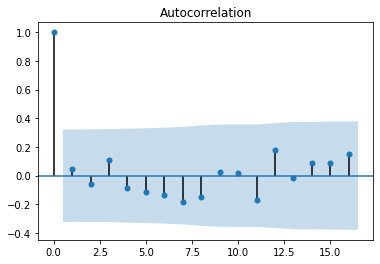

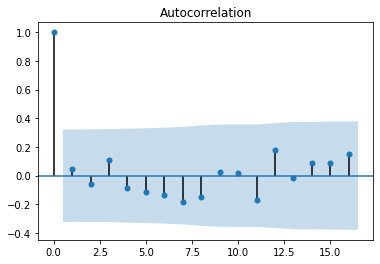

In [ ]:
#METODE ARIMA
selisih_ARIMA1 = test1["Harga_Antam"]-test1["Peramalan_Arima"]
sm.graphics.tsa.plot_acf(selisih_ARIMA1)

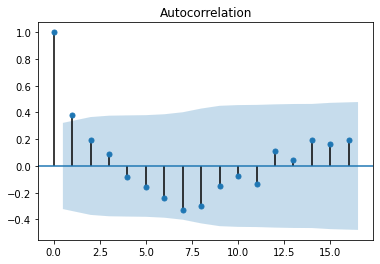

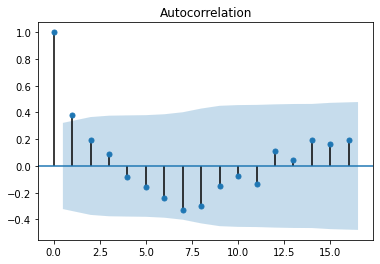

In [ ]:
#METODE SUPPORT VECTOR REGRESSION
selisih_SVR1 = test1["Harga_Antam"]-prediction_SVR
sm.graphics.tsa.plot_acf(selisih_SVR1)

SKENARIO 2

In [ ]:
#MEMBUAT PLOT PERBANDINGAN ANTARA HASIL PERAMALAN AKTUAL, METODE ARIMA DAN SUPPORT VECTOR REGRESSION PADA SKENARIO 2
#MELIHAT GRAFIK SKENARIO 2
#Memanggil fungsi untuk keluar grafik di notebook yang sama
output_notebook()

#buat source
sourcet2 = ColumnDataSource(trainer2)
source2 = ColumnDataSource(test2)

#membuat figure
awal2 = figure(x_axis_type='datetime', x_axis_label='Tanggal', y_axis_label='Harga Logam Mulia Antam')
awal2.line(x="Tanggal", y="Harga_Antam", source = source2, line_width=2, legend_label="Harga Logam Mulia Antam", color='deepskyblue')
awal2.line(x="Tanggal", y="Peramalan_Arima", source = source2, line_width=2, legend_label="Peramalan ARIMA", color='lime')
awal2.line(x="Tanggal", y="Peramalan_SVR", source = source2, line_width=2, legend_label="Peramalan SVR", color='tomato')
awal2.legend.location = 'top_left'

#membuat hover
hover22 = HoverTool()
hover22.tooltips = [('IDR ','@Harga_Antam'),('Peramalan Arima ', '@Prediksi_Arima'),('Peramalan SVR ', '@Peramalan_SVR')]
awal2.add_tools(hover22)

t2 = Title()
t2.text = "SKENARIO B - ARIMA VS SVR"
awal2.title = t2

#menampilkan grafik
show(awal2)

In [ ]:
hasilperamalan2 = test2
hasilperamalan2.drop(["et","diff","residu"],axis=1)

,Tanggal,Harga_Antam,Peramalan_Arima,Peramalan_SVR
165,2020-12-13,954000,954214.322394,958052.584645
166,2020-12-14,952000,954212.732540,958414.948724
167,2020-12-15,951000,952214.737429,957407.771344
168,2020-12-16,962000,951214.349259,956835.280232
169,2020-12-17,965000,962214.224610,965050.025371
170,2020-12-18,972000,965215.681435,967052.490504
171,2020-12-19,970000,972213.561298,973815.195142
172,2020-12-20,970000,970213.128849,973024.955342
173,2020-12-21,976000,970214.995928,972568.287317
174,2020-12-22,970000,976212.809251,976424.891633


PLOT ACF UNTUK MELIHAT KORELASI ANTAR RESIDU DARI HASIL YANG TELAH DIDAPAT

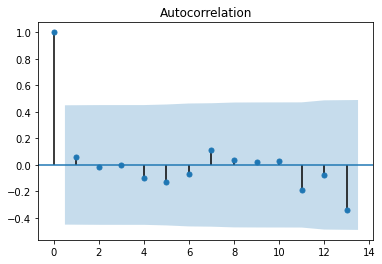

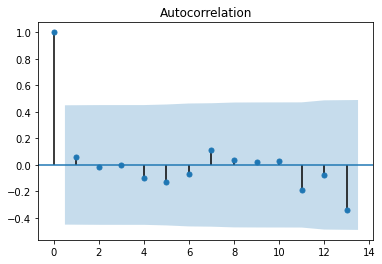

In [ ]:
#METODE SUPPORT VECTOR REGRESSION
selisih_SVR2 = test2["Harga_Antam"]-prediction_SVR2
sm.graphics.tsa.plot_acf(selisih_SVR2)

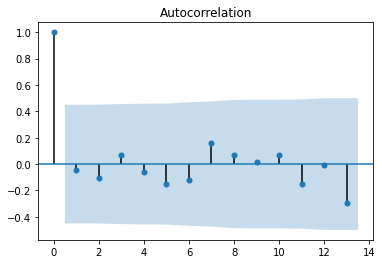

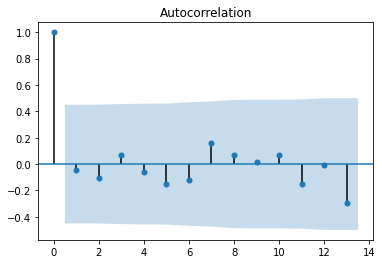

In [ ]:
#METODE ARIMA
selisih_ARIMA2 = test2["Harga_Antam"]-test2["Peramalan_Arima"]
sm.graphics.tsa.plot_acf(selisih_ARIMA2)

SKENARIO 3

In [ ]:
#MEMBUAT PLOT PERBANDINGAN ANTARA HASIL PERAMALAN AKTUAL, METODE ARIMA DAN SUPPORT VECTOR REGRESSION PADA SKENARIO 3
#Memanggil fungsi untuk keluar grafik di notebook yang sama
output_notebook()

#buat source
sourcet3 = ColumnDataSource(trainer3)
source3 = ColumnDataSource(test3)

#membuat figure
awal3 = figure(x_axis_type='datetime', x_axis_label='Tanggal', y_axis_label='Harga Logam Mulia Antam')
awal3.line(x="Tanggal", y="Harga_Antam", source = source3, line_width=2, legend_label="Harga Logam Mulia Antam", color='deepskyblue')
awal3.line(x="Tanggal", y="Peramalan_Arima", source = source3, line_width=2, legend_label="Peramalan ARIMA", color='lime')
awal3.line(x="Tanggal", y="Peramalan_SVR", source = source3, line_width=2, legend_label="Peramalan SVR", color='tomato')
awal3.legend.location = 'top_left'

#membuat hover
hover33 = HoverTool()
hover33.tooltips = [('IDR ','@Harga_Antam'),('Prediksi Arima ', '@Peramalan_Arima'),('Prediksi SVR ', '@Peramalan_SVR')]
awal3.add_tools(hover33)

t3 = Title()
t3.text = "SKENARIO C - ARIMA VS SVR"
awal3.title = t3

#menampilkan grafik
show(awal3)

In [ ]:
hasilperamalan3 = test3
hasilperamalan3.drop(["et","diff","residu"],axis=1)

,Tanggal,Harga_Antam,Peramalan_Arima,Peramalan_SVR
174,2020-12-22,970000,976294.065155,976334.633583
175,2020-12-23,966000,970297.123692,972376.571435
176,2020-12-24,971000,966294.936037,970297.882131
177,2020-12-25,973000,971294.174120,974271.695187
178,2020-12-26,973000,973294.410257,975239.755101
179,2020-12-27,973000,973294.540555,975293.032844
180,2020-12-28,977000,973294.901850,976178.823863
181,2020-12-29,967000,977294.558776,979436.960182
182,2020-12-30,965000,967295.755710,971122.796885
183,2020-12-31,965000,965292.560484,970518.434593


PLOT ACF UNTUK MELIHAT KORELASI ANTAR RESIDU DARI HASIL YANG TELAH DIDAPAT

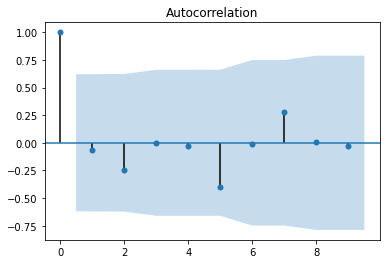

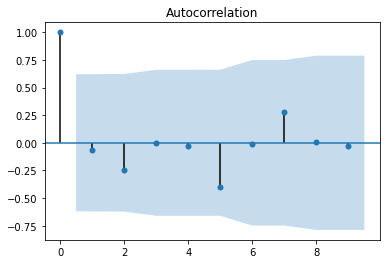

In [ ]:
#METODE ARIMA
selisih_ARIMA3 = test3["Harga_Antam"]-test3["Peramalan_Arima"]
sm.graphics.tsa.plot_acf(selisih_ARIMA3)

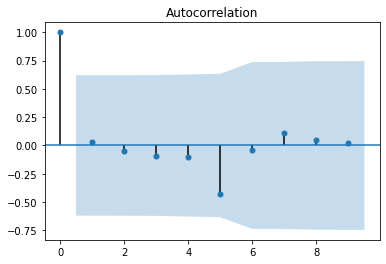

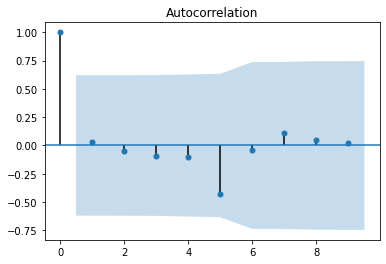

In [ ]:
#METODE SUPPORT VECTOR REGRESSION
selisih_SVR3 = test3["Harga_Antam"]-prediction_SVR3
sm.graphics.tsa.plot_acf(selisih_SVR3)

In [ ]:
#MEMBUAT DATAFRAME UNTUK HASIL MAE PADA SETIAP METODE & SKENARIO
maeArima = [maec, maef, maed]
maeSVR = [mae_SVR, mae_SVR2, mae_SVR3]
datamae = {"Hasil MAE ARIMA" : maeArima, "Hasil MAE SVR" : maeSVR}
dfmae = pd.DataFrame (datamae, columns = ['Hasil MAE ARIMA','Hasil MAE SVR'])
dfmae

,Hasil MAE ARIMA,Hasil MAE SVR
0,3697.484028,5681.764757
1,3477.009928,4345.966803
2,3417.900262,4411.717382


In [ ]:
#MEMASUKAN DATA KE DALAM DATABASE
from google.colab import drive
data.to_csv('hasildiffARIMA.csv')
!cp hasildiffARIMA.csv "/content/DB"

In [ ]:
test1.to_csv('hasilskenario1.csv')
!cp hasilskenario1.csv "/content/DB"

In [ ]:
test2.to_csv('hasilskenario2.csv')
!cp hasilskenario2.csv "/content/DB"

In [ ]:
test3.to_csv('hasilskenario3.csv')
!cp hasilskenario3.csv "/content/DB"